In [2]:
import os
import pickle

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.stats import linregress
from sklearn.decomposition import PCA

In [3]:
# Load only the data from the H5 file

site_dir = 'site'

fname = os.path.join(site_dir, 'time_series.h5')
data = pd.read_hdf(fname, 'data')
uncertainties = pd.read_hdf(fname, 'uncertainty')

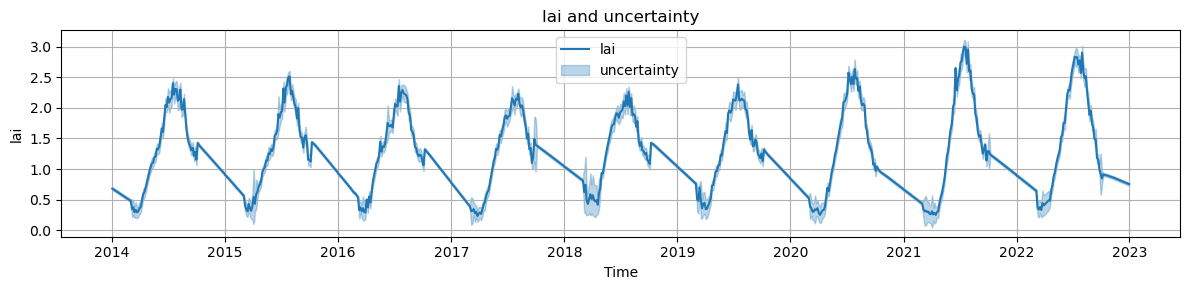

In [4]:
# Set the time range for plotting
start_time = pd.to_datetime('2014-01-01')
end_time = pd.to_datetime('2024-12-31')

# Ensure data and uncertainties have the same columns and index
common_vars = [col for col in data.columns if col in uncertainties.columns]
common_vars = ['lai']

fig, axes = plt.subplots(len(common_vars), 1, figsize=(12, 3*len(common_vars)), sharex=True)
if len(common_vars) == 1:
    axes = [axes]

for i, var in enumerate(common_vars):    
    series = data[var].loc[start_time:end_time]
    stddev = np.sqrt(uncertainties[var].loc[start_time:end_time])
    axes[i].plot(series.index, series.values, label=var, color='C0')
    axes[i].fill_between(series.index, series.values - stddev.values, series.values + stddev.values,
                         color='C0', alpha=0.3, label='uncertainty')
    axes[i].set_ylabel(var)
    axes[i].set_title(f'{var} and uncertainty')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [31]:
# Compute daily climatology and standardized anomalies for each variable
# The climatology mean is weighted by the inverse variance (from uncertainties)
# The standard deviation is the standard deviation of the values for each day of year (not weighted)
# Drop 29 February from the time series for climatology, use 28 February climatology for 29 February in z-score calculation

climatology_mean = {}
climatology_std = {}
anomalies = {}

for var in data:
    series = data[var].copy()
    variance = uncertainties[var].copy()
    
    # Drop 29 February
    mask = ~((series.index.month == 2) & (series.index.day == 29))
    series = series[mask]
    variance = variance[mask]
    dayofyear = series.index.dayofyear
    
    # Prepare DataFrame for groupby
    df = pd.DataFrame({'value': series, 'variance': variance, 'dayofyear': dayofyear})
    
    # Weighted mean for each day of year
    def weighted_mean(group):
        vals = group['value']
        vars_ = group['variance']
        weights = 1.0 / vars_.replace(0, np.nan)
        return np.nansum(vals * weights) / np.nansum(weights)
    
    clim_mean = df.groupby('dayofyear')[['value', 'variance']].apply(weighted_mean)
    clim_std = df.groupby('dayofyear')['value'].std()
    climatology_mean[var] = clim_mean
    climatology_std[var] = clim_std
    
    # Compute anomaly and standardized anomaly for all days (including 29 Feb)
    full_series = data[var]
    full_dayofyear = full_series.index.dayofyear
    
    # For 29 Feb, use 28 Feb climatology
    is_feb29 = (full_series.index.month == 2) & (full_series.index.day == 29)
    full_dayofyear_adj = pd.Series(full_dayofyear, index=full_series.index)
    full_dayofyear_adj[is_feb29] = 59  # 28 Feb is always day 59
    anomaly = full_series - clim_mean.reindex(full_dayofyear_adj).values
    std_anomaly = anomaly / clim_std.reindex(full_dayofyear_adj).values
    anomalies[var] = std_anomaly

climatology_mean_df = pd.DataFrame(climatology_mean)
climatology_std_df = pd.DataFrame(climatology_std)
anomalies_df = pd.DataFrame(anomalies)

/tmp/ipykernel_935330/3735537275.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return np.nansum(vals * weights) / np.nansum(weights)


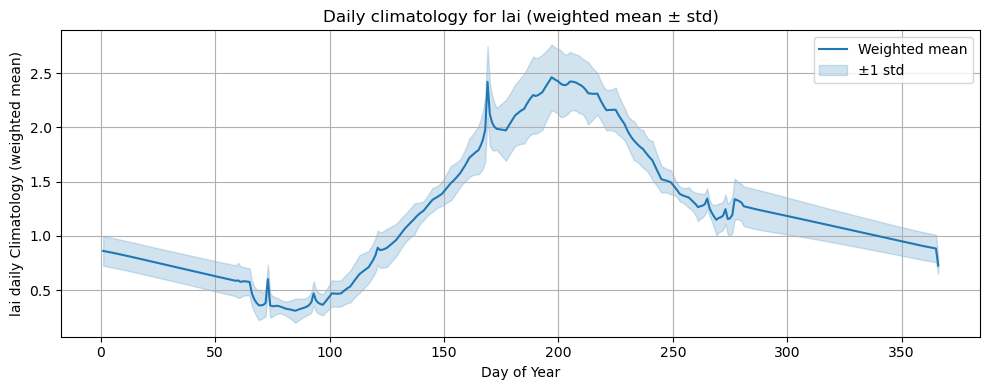

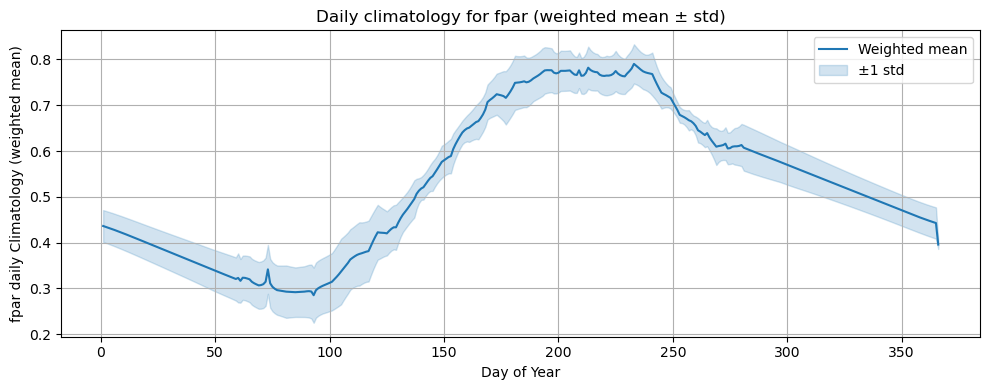

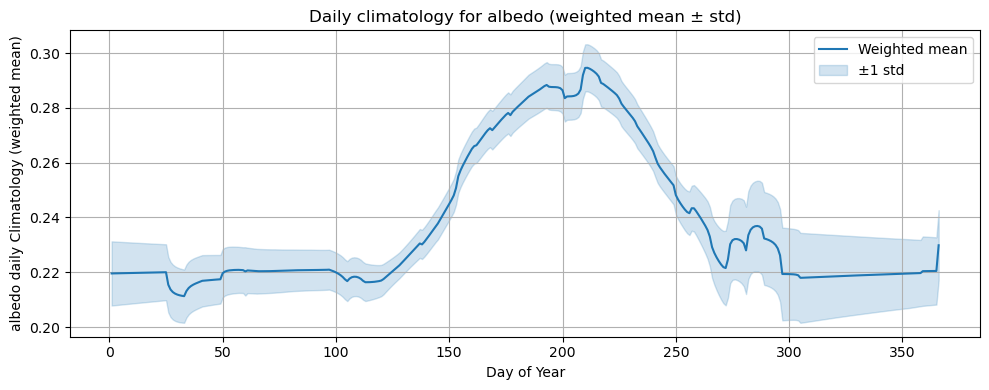

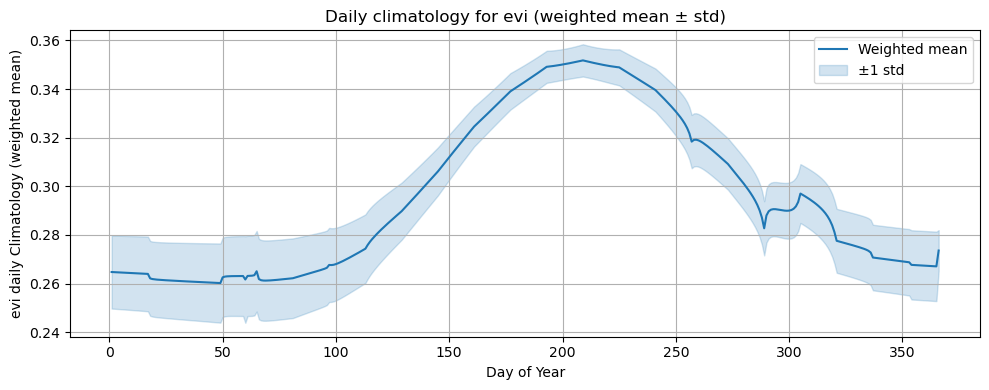

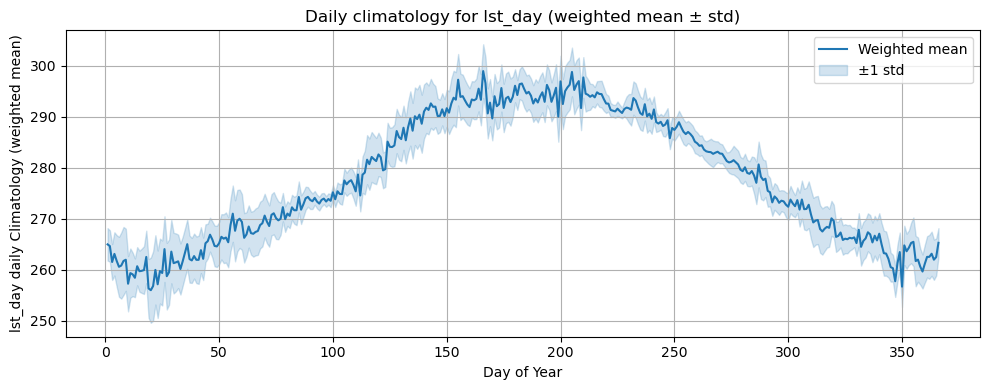

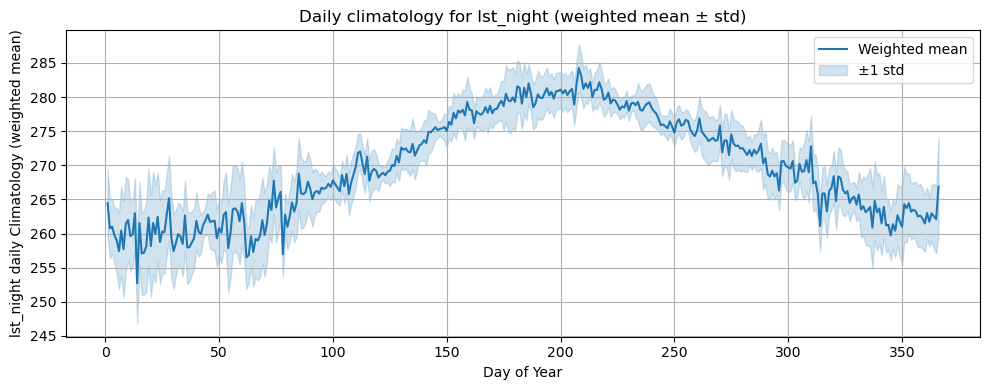

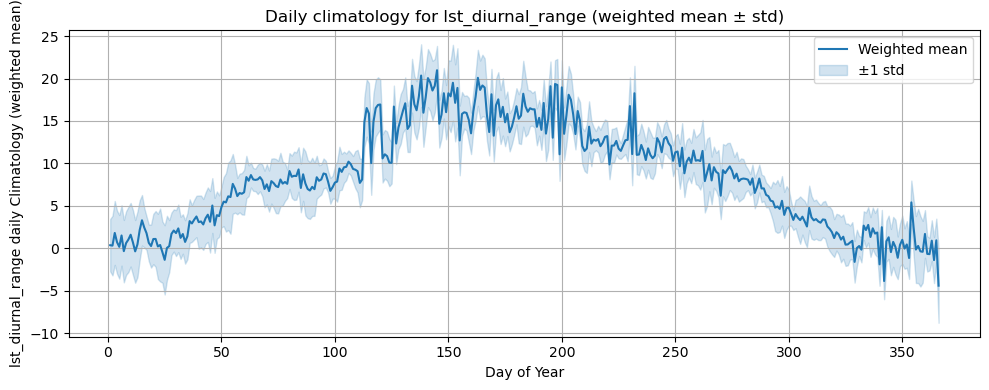

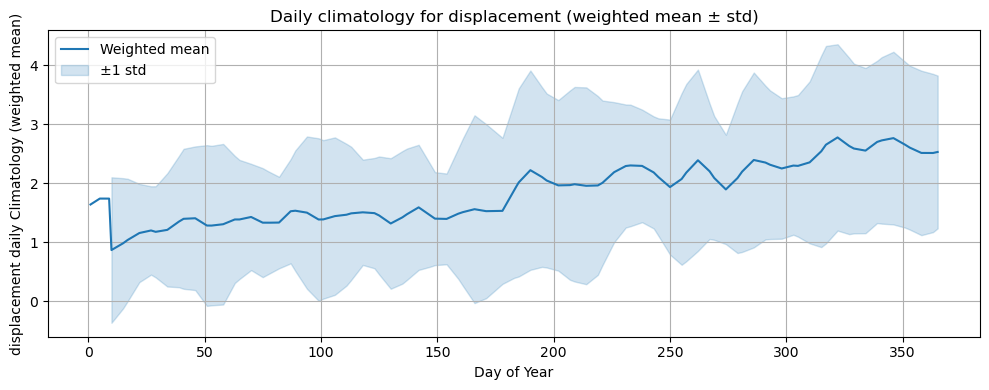

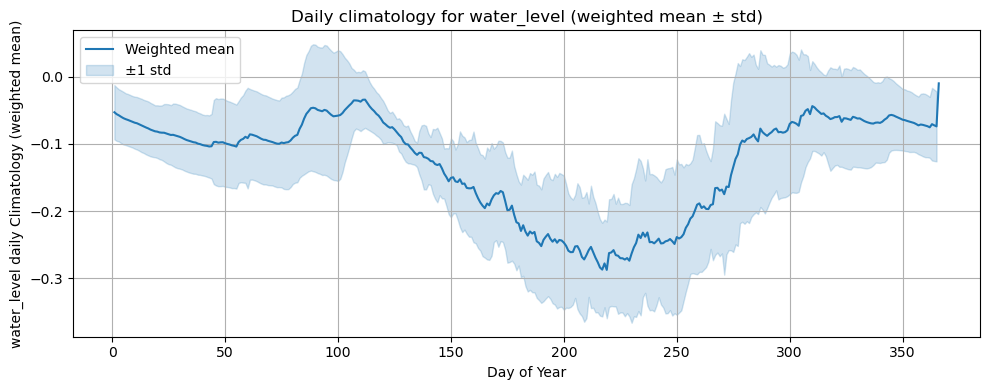

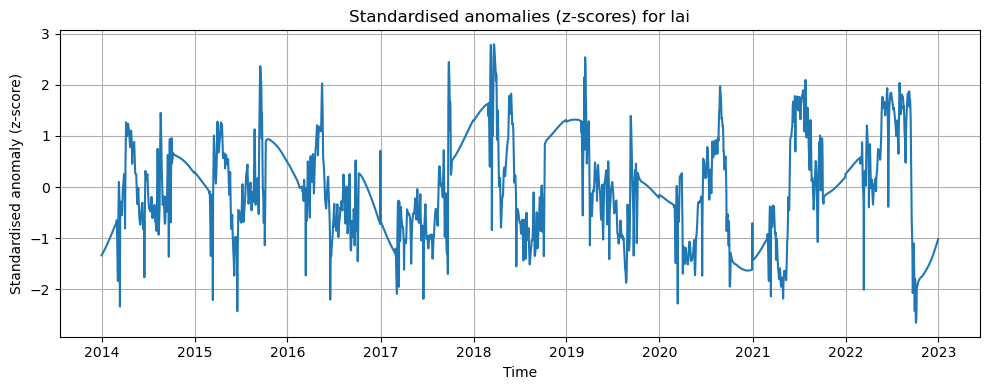

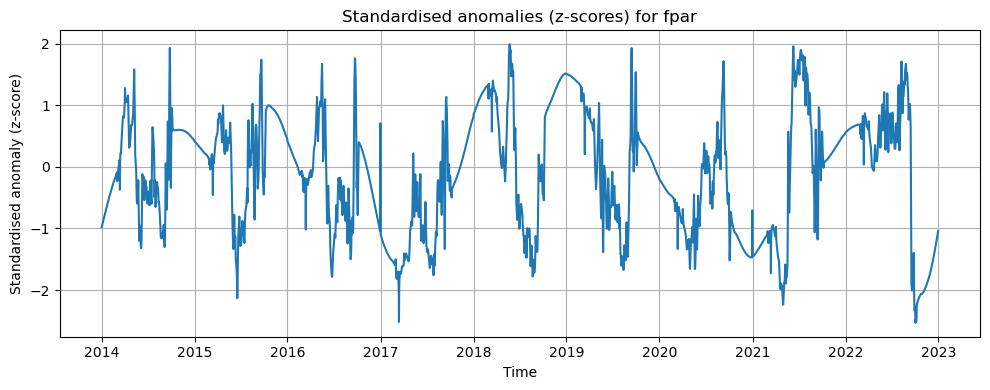

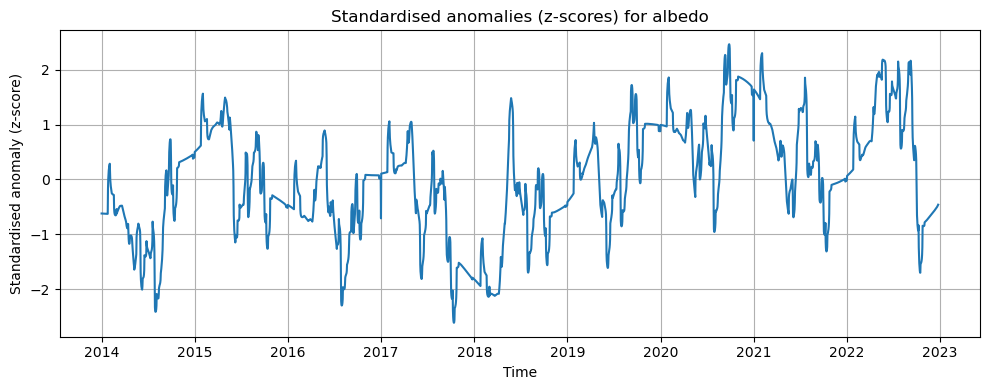

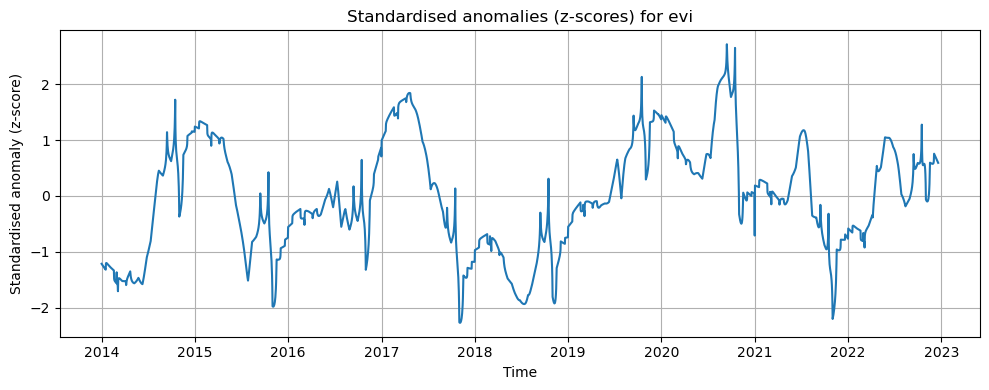

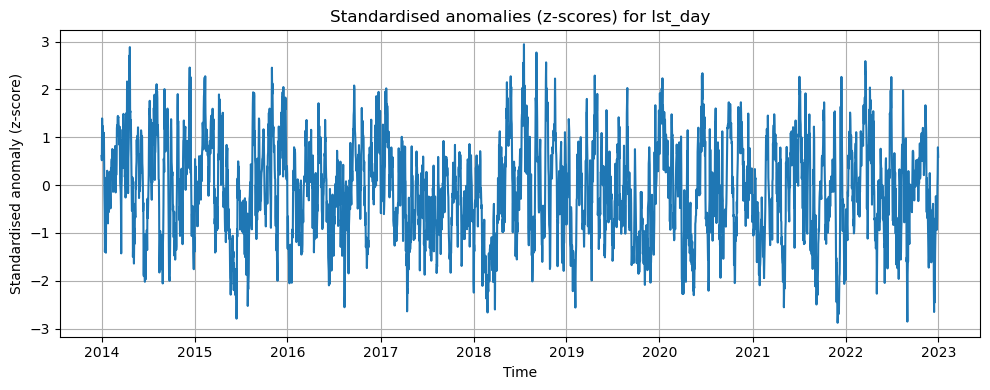

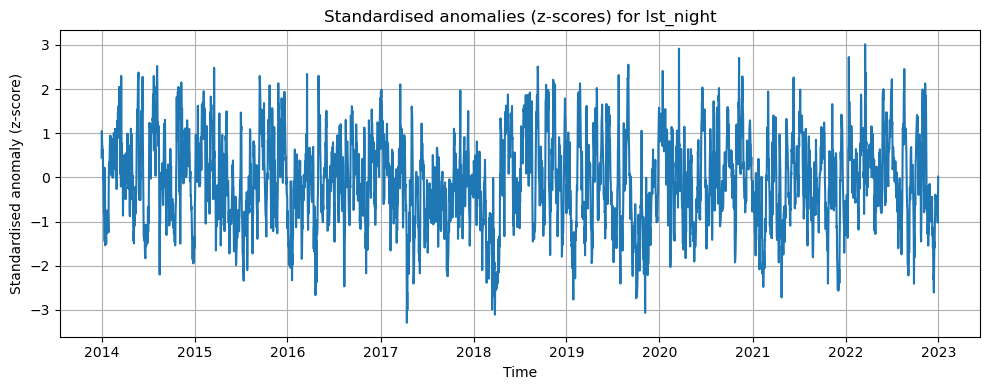

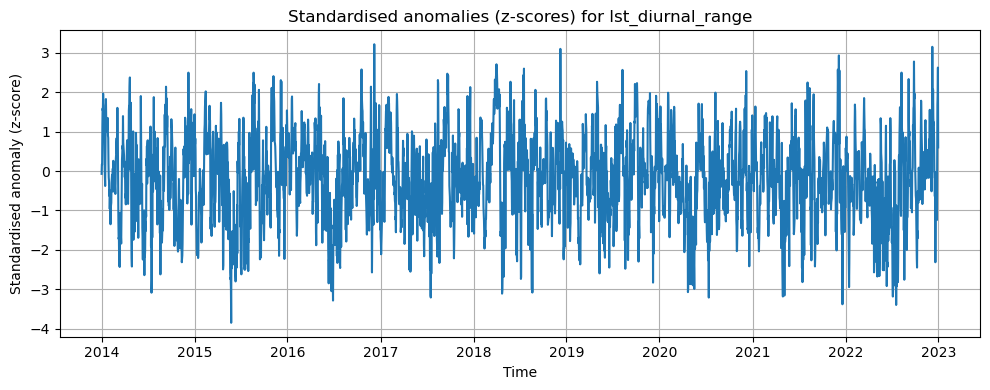

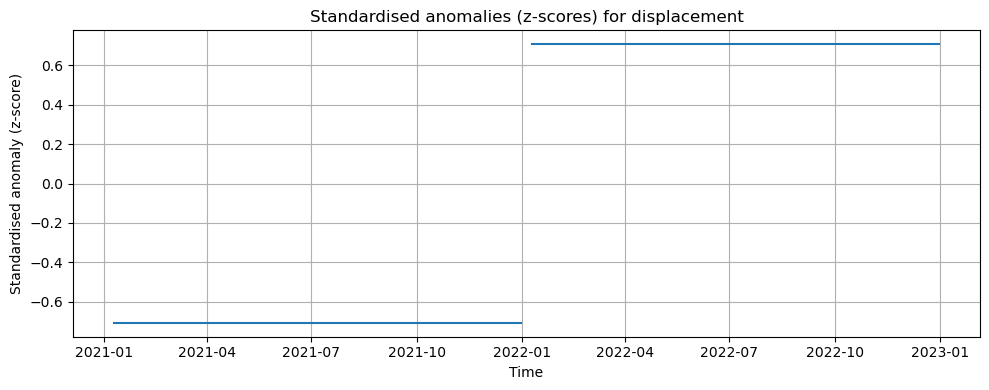

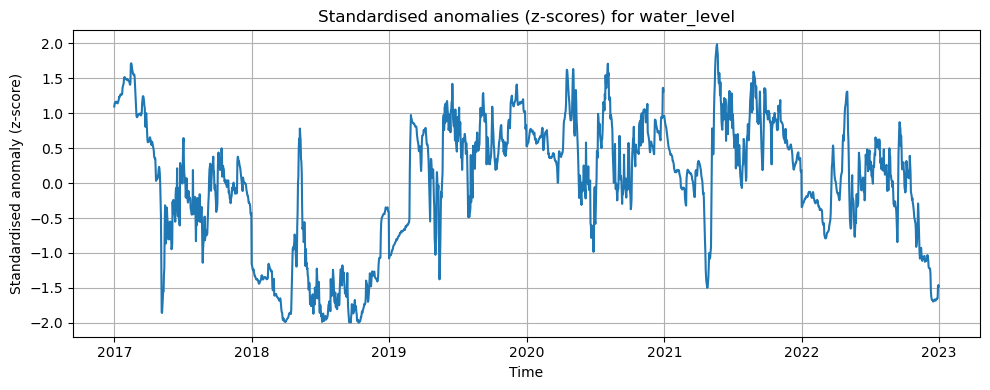

In [ ]:
# Individual plots for daily climatology
for var in climatology_mean_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(climatology_mean_df.index, climatology_mean_df[var], label='Weighted mean')
    plt.fill_between(
        climatology_mean_df.index,
        climatology_mean_df[var] - climatology_std_df[var],
        climatology_mean_df[var] + climatology_std_df[var],
        color='C0', alpha=0.2, label='±1 std')
    plt.xlabel('Day of Year')
    plt.ylabel(f'{var} daily Climatology (weighted mean)')
    plt.title(f'Daily climatology for {var} (weighted mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Individual plots for standardized anomalies (z-scores)
for var in anomalies_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(anomalies_df.index, anomalies_df[var], label=f'{var} z-score')
    plt.xlabel('Time')
    plt.ylabel('Standardised anomaly (z-score)')
    plt.title(f'Standardised anomalies (z-scores) for {var}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Compute the z-scores for each variable in data
zscore_data = {product: zscore(series) for product, series in data.items()}

# Plot the z-scores for each variable
fig, ax = plt.subplots(len(data), 1, sharex=True, figsize=(10, 8))

for i, (product, series) in enumerate(zscore_data.items()):
    ax[i].plot(series, color=colours[i])
    ax[i].set_title(f'{var_names[i]} - {product} z-score')
    ax[i].set_ylabel(f'z-score [unitless]')
    ax[i].grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [ ]:
# Convert zscore_data into a DataFrame
zscore_df = pd.DataFrame(zscore_data)

# Interpolate missing values
df_interpolated = zscore_df.interpolate(method='linear', limit_direction='both')
    
# Apply PCA
pca = PCA()
principal_components = pca.fit(df_interpolated)

# Extract the loadings (principal component coefficients) - first principal component
loadings = principal_components.components_[0]

# Compute weights as absolute values of loadings (normalised)
weights = np.abs(loadings) / np.sum(np.abs(loadings))
weights

In [ ]:
# Applying weights to create the Peatland Health Index
phi = np.dot(df_interpolated, weights)
phi_df = pd.DataFrame(phi, index=zscore_df.index, columns=['PHI'])

In [ ]:
# Add the PHI to the original data
data['PHI'] = phi_df

# Plot all variables in data with a shared x axis
fig, ax = plt.subplots(len(data), 1, sharex=True, figsize=(12, 8))

var_names = ['LAI', 'Albedo', 'LST_diff', 'Peatland Health Index']
colours = ['#2CA02C', '#7F7F7F', '#D92728', 'blue']
units = ['m$^2$/m$^2$', '%', 'K', 'unitless']

for i, (product, series) in enumerate(data.items()):
    ax[i].plot(series, color=colours[i])
    ax[i].set_title(f'{var_names[i]} - {product}')
    ax[i].grid(True)
    ax[i].set_ylabel(f'{units[i]}')

    # Add trend line for PHI
    if product == 'PHI':
        x = series.index.map(pd.Timestamp.toordinal).values
        slope, intercept, r_value, p_value, std_err = linregress(x, series.values[:,0])
        trend_line = slope * x + intercept
        ax[i].plot(series.index, trend_line, color='black', linestyle='--', label='PHI trend')
        ax[i].legend(loc='lower right')
        # ax[i].text(0.05, 0.5, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR^2: {r_value**2:.2f}\nP-value: {p_value:.2e}', 
        #           transform=ax[i].transAxes, fontsize=10, verticalalignment='top')

plt.xlabel('Time')
plt.tight_layout()
plt.show()


In [ ]:
# Original weights from PCA
# 'LAI', 'Albedo', 'LST'
# array([0.0678058 , 0.46359828, 0.46859592])

# User-defined weights
weights = np.array([0.2, 0.2, -0.6])

# Applying weights to create the Peatland Health Index
phi = np.dot(df_interpolated, weights)
phi_df = pd.DataFrame(phi, index=zscore_df.index, columns=['PHI'])


In [ ]:
# Add the PHI to the original data
data['PHI'] = phi_df

# Plot all variables in data with a shared x axis
fig, ax = plt.subplots(len(data), 1, sharex=True, figsize=(12, 8))

for i, (product, series) in enumerate(data.items()):
    ax[i].plot(series, color=colours[i])
    ax[i].set_title(f'{var_names[i]} - {product}')
    ax[i].grid(True)
    ax[i].set_ylabel(f'{units[i]}')

    # Add trend line for PHI
    if product == 'PHI':
        x = series.index.map(pd.Timestamp.toordinal).values
        slope, intercept, r_value, p_value, std_err = linregress(x, series.values[:,0])
        trend_line = slope * x + intercept
        ax[i].plot(series.index, trend_line, color='black', linestyle='--', label='PHI trend')
        ax[i].legend(loc='lower right')
        # ax[i].text(0.05, 0.5, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR^2: {r_value**2:.2f}\nP-value: {p_value:.2e}', 
        #           transform=ax[i].transAxes, fontsize=10, verticalalignment='top')

plt.xlabel('Time')
plt.tight_layout()
plt.show()